<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Lab 3.02: Statistical Modeling and Model Validation

> Authors: Tim Book, Matt Brems

---

## Objective
The goal of this lab is to guide you through the modeling workflow to produce the best model you can. In this lesson, you will follow all best practices when slicing your data and validating your model. 

## Imports

In [4]:
# Import everything you need here.
# You may want to return to this cell to import more things later in the lab.
# DO NOT COPY AND PASTE FROM OUR CLASS SLIDES!
# Muscle memory is important!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from scipy import stats
import sklearn
import pandas.util.testing as tm


## Read Data
The `citibike` dataset consists of Citi Bike ridership data for over 224,000 rides in February 2014.

In [5]:
# Read in the citibike data in the data folder in this repository.
df = pd.read_csv('./data/citibike_feb2014.csv')

## Explore the data
Use this space to familiarize yourself with the data.

Convince yourself there are no issues with the data. If you find any issues, clean them here.

In [6]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,382,2014-02-01 00:00:00,2014-02-01 00:06:22,294,Washington Square E,40.730494,-73.995721,265,Stanton St & Chrystie St,40.722293,-73.991475,21101,Subscriber,1991,1
1,372,2014-02-01 00:00:03,2014-02-01 00:06:15,285,Broadway & E 14 St,40.734546,-73.990741,439,E 4 St & 2 Ave,40.726281,-73.989780,15456,Subscriber,1979,2
2,591,2014-02-01 00:00:09,2014-02-01 00:10:00,247,Perry St & Bleecker St,40.735354,-74.004831,251,Mott St & Prince St,40.723180,-73.994800,16281,Subscriber,1948,2
3,583,2014-02-01 00:00:32,2014-02-01 00:10:15,357,E 11 St & Broadway,40.732618,-73.991580,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,17400,Subscriber,1981,1
4,223,2014-02-01 00:00:41,2014-02-01 00:04:24,401,Allen St & Rivington St,40.720196,-73.989978,439,E 4 St & 2 Ave,40.726281,-73.989780,19341,Subscriber,1990,1


In [7]:
df.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                  object
gender                       int64
dtype: object

## Is average trip duration different by gender?

Conduct a hypothesis test that checks whether or not the average trip duration is different for `gender=1` and `gender=2`. Be sure to specify your null and alternative hypotheses, and to state your conclusion carefully and correctly!

In [8]:
gender_1 = df.loc[df["gender"] == 1, 'tripduration']
gender_2 = df.loc[df["gender"] == 2, 'tripduration']
# adapted from Riley Dallas  - lesson 3.06

In [9]:
gender_1.shape

(176526,)

In [10]:
(gender_1.mean(),gender_2.mean())

(814.0324088236293, 991.3610742785506)

In [11]:
stats.ttest_ind(gender_1, gender_2, equal_var=False)
t_stat, p_value = stats.ttest_ind(gender_1, gender_2, equal_var=False)
print('The t_stat is {}'.format(t_stat))
print('The p_value is {}'.format(p_value))


The t_stat is -4.802922158264667
The p_value is 1.5680482053980446e-06


#### Significance level is .05
#### Null Hypothesis: is that there is no statistical difference in the mean trip duration between gender 1 and 2.
#### Alternative hypothesis: is that there is a statistical difference in the mean trip duration of gender 1 and 2

The p_value is extremely low meaning that the likelihood of the null hypothesis being true is very low.
We can reject it and say that the alternative hypothesis, that there is a difference in the mean trip duration of gender 1 and 2, is likely true.

## What numeric columns shouldn't be treated as numeric?

Start Station Id and End Station Id should not be numeric.

In [12]:
df.astype({'start station id': 'object','end station id':'object'}).dtypes # changing end and start stations to objects

tripduration                 int64
starttime                   object
stoptime                    object
start station id            object
start station name          object
start station latitude     float64
start station longitude    float64
end station id              object
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                  object
gender                       int64
dtype: object

## Dummify the `start station id` Variable

In [13]:
df = pd.get_dummies(df, columns = ["start station id"], drop_first = True)


In [14]:
df = pd.get_dummies(df, columns = ["usertype"], drop_first = True)



In [15]:
df['birth_year'] = df['birth year']

In [16]:
df = df.astype({'starttime': 'datetime64','stoptime':'datetime64',})

In [17]:
df['birth_year'].unique()

array(['1991', '1979', '1948', '1981', '1990', '1978', '1944', '1983',
       '1969', '1986', '1962', '1965', '1942', '1989', '1980', '1957',
       '1951', '1992', '1971', '1982', '1968', '1984', '\\N', '1956',
       '1987', '1985', '1996', '1975', '1988', '1974', '1972', '1959',
       '1973', '1977', '1976', '1953', '1993', '1970', '1963', '1967',
       '1966', '1960', '1961', '1994', '1958', '1955', '1946', '1964',
       '1900', '1995', '1954', '1952', '1949', '1947', '1941', '1938',
       '1950', '1945', '1997', '1934', '1940', '1939', '1936', '1943',
       '1935', '1937', '1922', '1932', '1907', '1926', '1899', '1901',
       '1917', '1910', '1933', '1921', '1927', '1913'], dtype=object)

In [18]:
df = df[df['birth_year'] != '\\N'] # handling string in the data

In [19]:
df = df.astype({'birth_year':'int64'})

In [20]:
df.dtypes

tripduration                       int64
starttime                 datetime64[ns]
stoptime                  datetime64[ns]
start station name                object
start station latitude           float64
                               ...      
start station id_2022              uint8
start station id_2023              uint8
start station id_3002              uint8
usertype_Subscriber                uint8
birth_year                         int64
Length: 343, dtype: object

## Engineer a feature called `age` that shares how old the person would have been in 2014 (at the time the data was collected).

- Note: you will need to clean the data a bit.

In [21]:
df['age'] = 2014 - df['birth_year']

In [22]:
cols = df.columns.tolist()
cols

['tripduration',
 'starttime',
 'stoptime',
 'start station name',
 'start station latitude',
 'start station longitude',
 'end station id',
 'end station name',
 'end station latitude',
 'end station longitude',
 'bikeid',
 'birth year',
 'gender',
 'start station id_79',
 'start station id_82',
 'start station id_83',
 'start station id_116',
 'start station id_119',
 'start station id_120',
 'start station id_127',
 'start station id_128',
 'start station id_137',
 'start station id_143',
 'start station id_144',
 'start station id_146',
 'start station id_147',
 'start station id_150',
 'start station id_151',
 'start station id_152',
 'start station id_153',
 'start station id_157',
 'start station id_160',
 'start station id_161',
 'start station id_164',
 'start station id_167',
 'start station id_168',
 'start station id_173',
 'start station id_174',
 'start station id_195',
 'start station id_212',
 'start station id_216',
 'start station id_217',
 'start station id_218',
 's

## Split your data into train/test data

Look at the size of your data. What is a good proportion for your split? **Justify your answer.**

Use the `tripduration` column as your `y` variable.

For your `X` variables, use `age`, `usertype`, `gender`, and the dummy variables you created from `start station id`. (Hint: You may find the Pandas `.drop()` method helpful here.)

**NOTE:** When doing your train/test split, please use random seed 123.

In [23]:
df_new = df.copy()

In [24]:
df_new.drop(columns = ['tripduration',
 'starttime','stoptime','start station name','start station latitude',
 'start station longitude','end station id','end station name','end station latitude','end station longitude',
 'bikeid', 'birth year','birth_year'],inplace=True)

In [25]:
features = df_new.columns.tolist()

In [26]:
features

['gender',
 'start station id_79',
 'start station id_82',
 'start station id_83',
 'start station id_116',
 'start station id_119',
 'start station id_120',
 'start station id_127',
 'start station id_128',
 'start station id_137',
 'start station id_143',
 'start station id_144',
 'start station id_146',
 'start station id_147',
 'start station id_150',
 'start station id_151',
 'start station id_152',
 'start station id_153',
 'start station id_157',
 'start station id_160',
 'start station id_161',
 'start station id_164',
 'start station id_167',
 'start station id_168',
 'start station id_173',
 'start station id_174',
 'start station id_195',
 'start station id_212',
 'start station id_216',
 'start station id_217',
 'start station id_218',
 'start station id_223',
 'start station id_224',
 'start station id_225',
 'start station id_228',
 'start station id_229',
 'start station id_232',
 'start station id_233',
 'start station id_236',
 'start station id_237',
 'start station i

In [27]:
X = df[features]
y = df['tripduration']


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state = 123)

## Fit a Linear Regression model in `sklearn` predicting `tripduration`.

In [43]:
lr = LinearRegression()
lr.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Evaluate your model
Look at some evaluation metrics for **both** the training and test data. 
- How did your model do? Is it overfit, underfit, or neither?
- Does this model outperform the baseline? (e.g. setting $\hat{y}$ to be the mean of our training `y` values.)

In [44]:
lr.score(X_train,y_train)

0.004837826345896246

In [46]:
lr = LinearRegression()
lr.fit(X_test,y_test)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
lr.score(X_test,y_test)

0.006252671355436612

## Fit a Linear Regression model in `statsmodels` predicting `tripduration`.

In [48]:
import statsmodels.api as sm


In [49]:
X = df[features]
y = df['tripduration']

In [50]:
model = sm.OLS(y, X).fit()

## Using the `statsmodels` summary, test whether or not `age` has a significant effect when predicting `tripduration`.
- Be sure to specify your null and alternative hypotheses, and to state your conclusion carefully and correctly **in the context of your model**!

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tripduration   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.074
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           6.57e-27
Time:                        18:04:34   Log-Likelihood:            -2.1860e+06
No. Observations:              218019   AIC:                         4.373e+06
Df Residuals:                  217688   BIC:                         4.376e+06
Df Model:                         330                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
gender                  180.1440     30.175      5.970      0.000     121.002     239.286
start station id_79     -26.2456    308.982     -0.085      0.932    -631.843     579.352
start station id_82     252.6224    396.809      0.637      0.524    -525.113    1030.357
start station id_83    -179.8400    391.833     -0.459      0.646    -947.823     588.143
start station id_116   -371.1954    263.562     -1.408      0.159    -887.769     145.379
start station id_119   -332.6262    769.802     -0.432      0.666   -1841.419    1176.166
start station id_120    761.4475    616.813      1.234      0.217    -447.490    1970.385
start station id_127   -315.3952    278.106     -1.134      0.257    -860.476     229.685
start station id_128   -322.6911    272.019     -1.186      0.236    -855.842     210.460
start station id_137   -344.0093    329.982     -1.043      0.297    -990.765     302.746
start station id_143   -319.8262    462.395     -0.692      0.489   -1226.108     586.456
start station id_144   -108.6615    629.266     -0.173      0.863   -1342.007    1124.684
start station id_146   -439.5083    326.263     -1.347      0.178   -1078.976     199.959
start station id_147   -100.5356    283.396     -0.355      0.723    -655.986     454.914
start station id_150     69.6500    321.161      0.217      0.828    -559.817     699.117
start station id_151   -379.4335    254.077     -1.493      0.135    -877.418     118.551
start station id_152   -388.1797    358.715     -1.082      0.279   -1091.252     314.893
start station id_153   -315.8560    277.090     -1.140      0.254    -858.945     227.233
start station id_157     74.1066    380.201      0.195      0.845    -671.079     819.292
start station id_160   -174.8963    308.723     -0.567      0.571    -779.985     430.193
start station id_161   -403.8267    270.036     -1.495      0.135    -933.090     125.437
start station id_164   -262.6243    306.409     -0.857      0.391    -863.178     337.929
start station id_167   -259.2073    281.321     -0.921      0.357    -810.590     292.175
start station id_168   -310.8359    263.761     -1.178      0.239    -827.801     206.130
start station id_173   -355.9212    281.936     -1.262      0.207    -908.509     196.666
start station id_174    280.9783    293.132      0.959      0.338    -293.553     855.509
start station id_195    278.6947    302.011      0.923      0.356    -313.239     870.629
start station id_212   -278.3274    279.501     -0.996      0.319    -826.142     269.487
start station id_216   -214.9922    694.187     -0.310      0.757   -1575.581    1145.597
start station id_217    -15.6061    616.822     -0.025      0.980   -1224.563    1193.350
start station id_218    191.9560    676.802      0.284      0.777   -1134.559    1518.471
start station id_223   

#### NUll Hypothesis is that age has no impact on trip duration
#### Alternatite Hypothesis is that age does have an impact on trip duration.

#### P_value is 0: This means that we can reject the null hypothesis and conclude that based on this model age does have a significant impact on trip duration.

## Citi Bike is attempting to market to people who they think will ride their bike for a long time. Based on your modeling, what types of individuals should Citi Bike market toward?

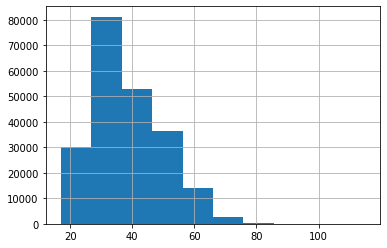

In [52]:
df['age'].hist()

In [ ]:
I would market towards people between the ages of 20 and 40.